# Project 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def gridify(fun, num_points, flat = False):
    x = np.linspace(0, 1, num_points)
    y = np.linspace(0, 2, num_points)
    xx, yy = np.meshgrid(x, y)
    grid = fun(xx, yy)
    if flat:
        return grid.flatten()
    else:
        return grid
    
def testfun(x, y):
    return x+y

print(gridify(testfun, 5))
print(gridify(testfun, 5, True))

[[0.   0.25 0.5  0.75 1.  ]
 [0.5  0.75 1.   1.25 1.5 ]
 [1.   1.25 1.5  1.75 2.  ]
 [1.5  1.75 2.   2.25 2.5 ]
 [2.   2.25 2.5  2.75 3.  ]]
[0.   0.25 0.5  0.75 1.   0.5  0.75 1.   1.25 1.5  1.   1.25 1.5  1.75
 2.   1.5  1.75 2.   2.25 2.5  2.   2.25 2.5  2.75 3.  ]


In [267]:
def dirichlet(boundaries, alpha = 1, beta = 1):
    """ Create a one-dimensional vector for Dirichlet conditions. Uses natural ordering.

    Args:
        G (array(4 x M-1)): Matrix with row vectors corresponding respectively to boundary at x = x0, y = y0, x = xend, y = yend
        alpha, beta (floats): Constants as defined in text. Optional arguments. 

    Returns:
        g (array(M-1)^2): One dimensional array meant for use in linear system, using natural ordering
    """
    l, t, r, b = boundaries
    M = l.shape[0] - 1         # l is M+1
    G = np.zeros((M-1, M-1))
    G[0, :] += beta * np.insert(b[2:M], 0, 0)
    G[-1, :] += beta * np.append(t[2: M],0)
    G[:, 0] += alpha * l[1:M] + beta * l[0:M-1]
    G[:, -1] += alpha * r[0:M-1] + beta * r[1:M]
    """plt.imshow(G)
    plt.show()"""
    return G.flatten()


# Testing
M = 10
l = np.arange(M+1)
t = np.arange(M+1)
r = np.arange(M+1)
b = np.arange(M+1)

g2 = dirichlet([l, t, r, b], 1, 1)
#G = np.flip(g2.reshape((M-1,M-1)), 0)
print(np.flip(g2.reshape((M-1,M-1)), 0))
#np.pad(G, [(1,1)])

[[19.  3.  4.  5.  6.  7.  8.  9. 17.]
 [15.  0.  0.  0.  0.  0.  0.  0. 15.]
 [13.  0.  0.  0.  0.  0.  0.  0. 13.]
 [11.  0.  0.  0.  0.  0.  0.  0. 11.]
 [ 9.  0.  0.  0.  0.  0.  0.  0.  9.]
 [ 7.  0.  0.  0.  0.  0.  0.  0.  7.]
 [ 5.  0.  0.  0.  0.  0.  0.  0.  5.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  3.]
 [ 1.  2.  3.  4.  5.  6.  7.  8. 10.]]


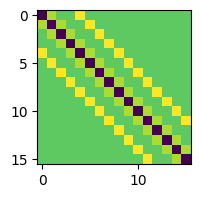

In [263]:
def ndiag(consts, offsets, N):
    """Generate a matrix with arbitrary number of constant diagonals, 0 elsewhere

    Args:
        consts (list of floats):    list containing floats on diagonal
        offsets (list of ints):     list of offsets. Corresponds to the consts list
        N (int):                    length of array

    Returns:
        A (N x N matrix):           matrix with diagonals as specified
    """
    diags = []
    for i in range(len(consts)):
        diags.append(consts[i] * np.ones(N - np.abs(offsets[i])))

    A = np.zeros((N,N))
    for i in range(len(diags)):
        A += np.diag(diags[i], offsets[i])
    return A

# Testing
"""N = 10
consts = [1, 3, 5, -1]
offsets = [0, 1, 2, -6]
A = ndiag(consts, offsets, N)
print(A)
"""
M = 5
alpha, beta = 1, 2
consts = [beta, alpha, -2*(alpha + beta), alpha, beta]
offsets = [-(M-1), -1, 0, 1, M-1]
A = ndiag(consts, offsets, (M-1)**2)
plt.figure(figsize = (2,2))
plt.imshow(A)
plt.show()

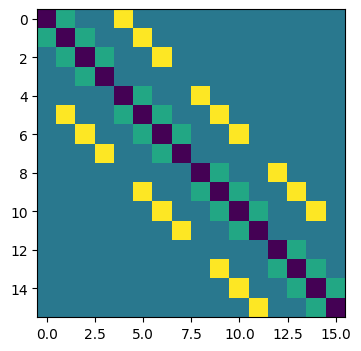

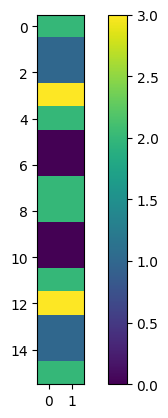

In [298]:
def triblock(C, B, D, M):
    A = np.kron(np.eye(M-1), C)
    A += np.kron(ndiag([1], [1], M-1), B)
    A += np.kron(ndiag([1], [-1], M-1), D)
    return A

# Testing
M = 5
C = ndiag([1,-2,1], [-1,0,1], (M-1))
B = 3 * np.eye(M-1)
B[-1,-1] = 0
D = 3 * np.eye(M-1)
D[0,0] = 0
A = triblock(C, B,D, M)

plt.figure(0, figsize = (4,4))
plt.imshow(A)
plt.show()

l = np.ones(M+1)
t = np.ones(M+1)
r = np.ones(M+1)
b = np.ones(M+1)

g2 = dirichlet([l, t, r, b], 1, 1)
plt.imshow(np.array([g2,g2]).T)
plt.colorbar()
plt.show()

## 1a)

In [291]:
def solver(f, boundaries, a, M):
    h = 1/M
    k = 2*h

    alpha = a / h**2
    beta = 1 / h**2
    consts = [alpha, -2*(alpha + beta), alpha]
    offsets = [-1, 0, 1]
    C = ndiag(consts, offsets, M-1)
    B = beta * np.eye(M-1)
    B[-1,-1] = 0
    A = triblock(C, B, M)
    g = dirichlet(boundaries, alpha, beta)
    U_vec = np.linalg.solve(A, -g + f)
    U = U_vec.reshape((M-1, M-1))
    return U

"""M = 50
f = np.ones((M-1)**2)

l = 5*np.sin(np.pi*np.arange(M+1)/(M+1))
t = 5*np.sin(np.pi*np.arange(M+1)/(M+1))
r = 5*np.sin(np.pi*np.arange(M+1)/(M+1))
b = 5*np.sin(np.pi*np.arange(M+1)/(M+1))
boundaries = [l,t,r,b]


a = 5"""
#U = solver(f, boundaries, a, M)

#plt.imshow(U, origin = 'lower')
#plt.colorbar()
#plt.show()
"""plt.plot(U[0,:])
plt.plot(np.flip(b))
plt.show()"""

'plt.plot(U[0,:])\nplt.plot(np.flip(b))\nplt.show()'

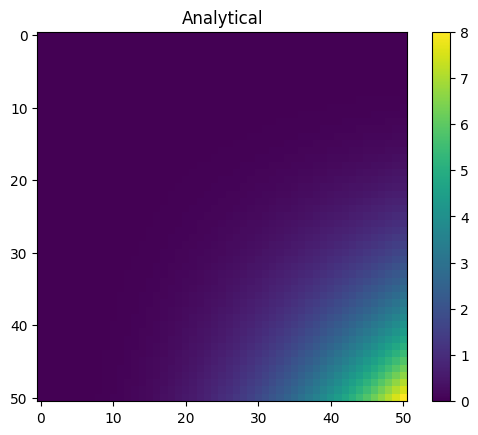

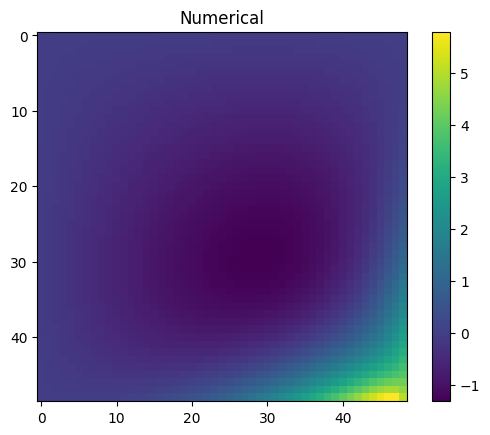

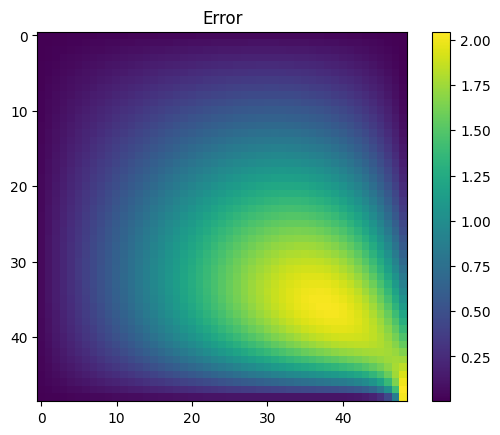

In [292]:
M = 50
h = 1/M
k = 2*h
r = 2
a = 1
x = np.linspace(0, 1, M+1)
y = np.linspace(0, 2, M+1)

def u_exact(x, y):
    return x**3 * y**3


def f(x, y):
    return 6 * (a+1)*x*y**3 + 18 * r * x**2 * y**2 + 6 * r**2 * x**3 * y
xx, yy = np.meshgrid(x, y)
fvec = f(xx, yy)[1:-1, 1:-1]
"""plt.imshow(fvec)
plt.colorbar()
plt.show()"""

U_exact = u_exact(xx, yy)
b = U_exact[0, :]
t = U_exact[-1, :]
l = U_exact[:, 0]
r = U_exact[:, -1]
boundaries = [l,t,r,b]

plt.title('Analytical')
plt.imshow(U_exact)
plt.colorbar()
plt.show()

U = solver(fvec.flatten(), boundaries, a, M)
plt.title('Numerical')
plt.imshow(U.reshape((M-1,M-1)))
plt.colorbar()
plt.show()

plt.title('Error')
plt.imshow(np.abs(U.reshape((M-1, M-1)) - U_exact[1:-1,1:-1]))
plt.colorbar()
plt.show()

## 1c)

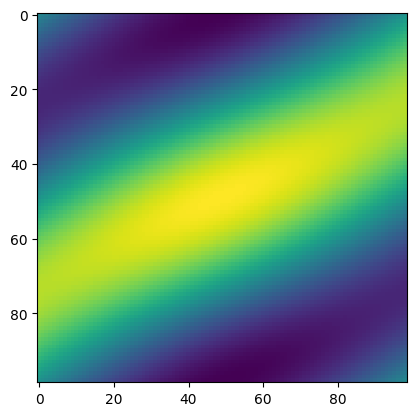

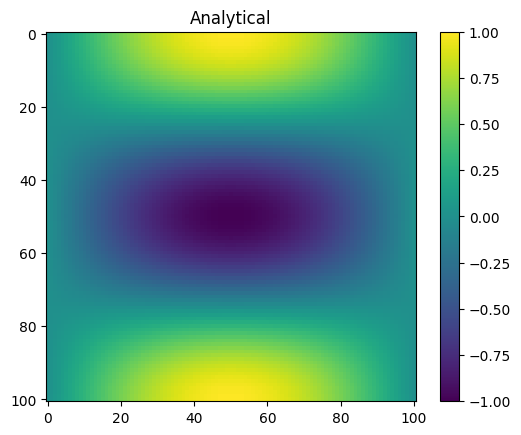

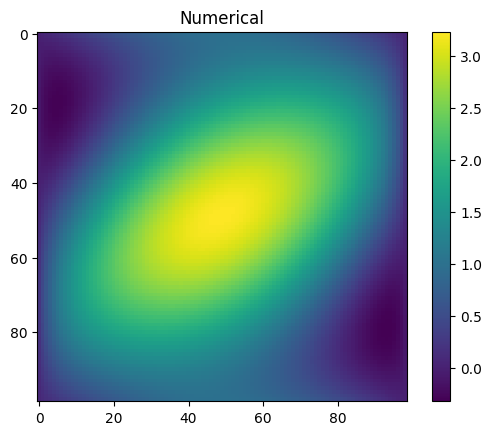

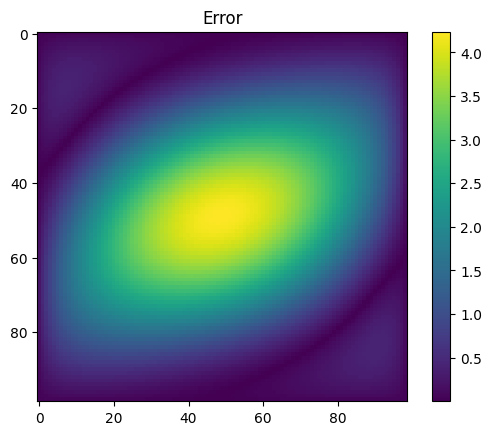

In [279]:
M = 100
h = 1/M
k = 2*h
r = 2
a = 0.1
x = np.linspace(0, 1, M+1)
y = np.linspace(0, 2, M+1)

def u_exact(x, y):
    return np.sin(np.pi * x) * np.cos(np.pi * y)
U_exact = gridify(u_exact, M+1)

def f(x, y):
    return np.pi**2 * ((-a-1-r**2) * np.sin(np.pi * x) * np.cos(np.pi * y) - 2*r * np.cos(np.pi * x) * np.sin(np.pi * y))
xx, yy = np.meshgrid(x, y)
fvec = f(xx, yy)[1:-1, 1:-1]
plt.imshow(fvec)
plt.show()

b = np.flip(U_exact[0, :])
t = U_exact[-1, :]
l = U_exact[:, 0]
r = np.flip(U_exact[:, -1])
boundaries = [l,t,r,b]
"""plt.figure(figsize = (3,3))
plt.plot(l, '-*', label = 'x = 0')
plt.plot(t, '-*', label = 'y = 2')
plt.plot(b, '-', label = 'y = 0')
plt.plot(r, '-', label = 'x = 1')
plt.legend()
plt.show()"""
plt.title('Analytical')
plt.imshow(U_exact)
plt.colorbar()
plt.show()
U = solver(fvec.flatten(), boundaries, a, M)
plt.title('Numerical')
plt.imshow(U.reshape((M-1,M-1)))
plt.colorbar()
plt.show()
plt.title('Error')
plt.imshow(np.abs(U.reshape((M-1, M-1)) - U_exact[1:-1,1:-1]))
plt.colorbar()
plt.show()

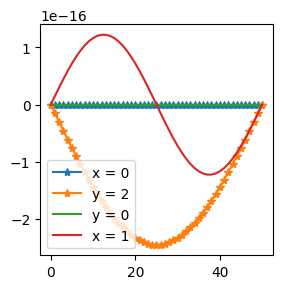

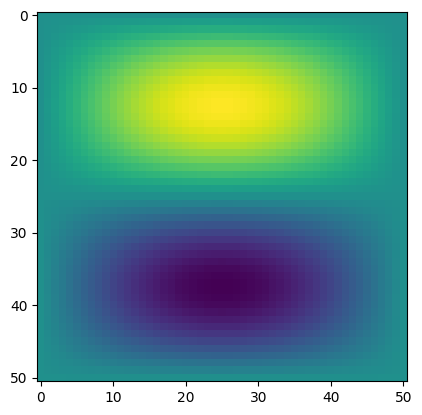

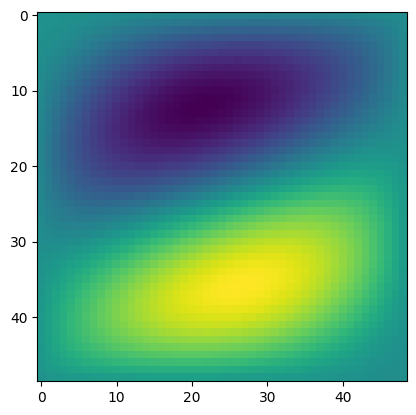

In [280]:
M = 50
h = 1/M
k = 2*h
r = 2
a = 1
x = np.linspace(0, 1, M+1)
y = np.linspace(0, 2, M+1)

def u_exact(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)
U_exact = gridify(u_exact, M+1)

def f(x, y):
    return np.pi**2 * ((-a-1-r**2) * np.sin(np.pi * x)* np.sin(np.pi * y) + 2*r * np.cos(np.pi * x)* np.cos(np.pi * y))
xx, yy = np.meshgrid(x, y)
fvec = f(xx, yy)[1:-1, 1:-1]

b = U_exact[0, :]
t = U_exact[-1, :]
l = U_exact[:, 0]
r = U_exact[:, -1]
boundaries = [l,t,r,b]
plt.figure(figsize = (3,3))
plt.plot(l, '-*', label = 'x = 0')
plt.plot(t, '-*', label = 'y = 2')
plt.plot(b, '-', label = 'y = 0')
plt.plot(r, '-', label = 'x = 1')
plt.legend()
plt.show()
plt.imshow(U_exact)
plt.show()
U = solver(fvec.flatten(), boundaries, a, M)
plt.imshow(U.reshape((M-1,M-1)))

2.0